In [13]:
# 1. Data Preparations
#=== 1.1Setting up Packages===
import numpy as np
import pandas as pd
import yfinance as yf
import requests
from fredapi import Fred
from ta.trend import EMAIndicator, MACD, CCIIndicator
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
import os

#=== 1.2 Creating folders ===
os.makedirs('01_data/raw_prices', exist_ok=True)
os.makedirs('01_data/processed', exist_ok=True)

# ===1.3 ETF Adj_Price Collection with yfinance (Weekly, Cleaned) ===
etfs = ['SPY', 'QQQ', 'SCHD', 'TLTW','GLD']

# Download daily data first (more flexible)
etf_prices_daily = yf.download(etfs, start='2015-01-01', end='2025-04-30', interval='1d', auto_adjust=True)['Close']

# Clean timezone
etf_prices_daily.index = pd.to_datetime(etf_prices_daily.index)
etf_prices_daily.index = etf_prices_daily.index.tz_localize(None)

# Resample to Weekly (Friday) + Forward Fill if Friday missing
etf_prices = (
    etf_prices_daily
    .resample('W-FRI')
    .ffill()  # Forward fill to avoid missing Friday prices
)

# Save cleaned weekly prices
etf_prices.to_csv('01_data/raw_prices/etf_weekly_prices.csv')
print("ETF prices collected with yfinance, forward-filled to Friday.")

# === 1.4  Macro Features Collection -Federal Fund Rate (FRED) ===
fred = Fred(api_key='API KEY')

macro_series = {
    'FEDFUNDS': 'fed_rate',                # Federal Funds Rate
}

macro_data_list = []

for code, name in macro_series.items():
    print(f" Downloading {name} from FRED...")
    temp = fred.get_series(code)
    temp = temp.to_frame(name)
    temp.index = pd.to_datetime(temp.index)
    macro_data_list.append(temp)

# Merge all macro features
macro_data = pd.concat(macro_data_list, axis=1)

# Align macro features to ETF weekly index
etf_prices = pd.read_csv('01_data/raw_prices/etf_weekly_prices.csv', index_col=0, parse_dates=True)
macro_data = macro_data.reindex(etf_prices.index)

# Fill missing macro data using forward fill, then backward fill any remaining NaN values
macro_data = macro_data.ffill()

# Save macro features
macro_data.to_csv('01_data/processed/macro_features_weekly.csv')
print("\n Macro features collected and aligned to weekly ETF data.")

# === 1.5 Merge All Data Together and Save it one csv file===
full_data = pd.concat([etf_prices, macro_data], axis=1)
full_data.to_csv('01_data/processed/etf_full_features_weekly.csv')
print(" Full dataset ready.")


[*********************100%***********************]  5 of 5 completed


ETF prices collected with yfinance, forward-filled to Friday.

 Macro features collected and aligned to weekly ETF data.
 Full dataset ready.


 4-week future returns (% scale) created.

 Training Prophet for SPY...


17:31:14 - cmdstanpy - INFO - Chain [1] start processing
17:31:14 - cmdstanpy - INFO - Chain [1] done processing
17:31:15 - cmdstanpy - INFO - Chain [1] start processing



 Training Prophet for QQQ...


17:31:15 - cmdstanpy - INFO - Chain [1] done processing
17:31:15 - cmdstanpy - INFO - Chain [1] start processing



 Training Prophet for SCHD...


17:31:15 - cmdstanpy - INFO - Chain [1] done processing
17:31:16 - cmdstanpy - INFO - Chain [1] start processing



 Training Prophet for TLTW...


17:31:16 - cmdstanpy - INFO - Chain [1] done processing
17:31:16 - cmdstanpy - INFO - Chain [1] start processing



 Training Prophet for GLD...


17:31:16 - cmdstanpy - INFO - Chain [1] done processing


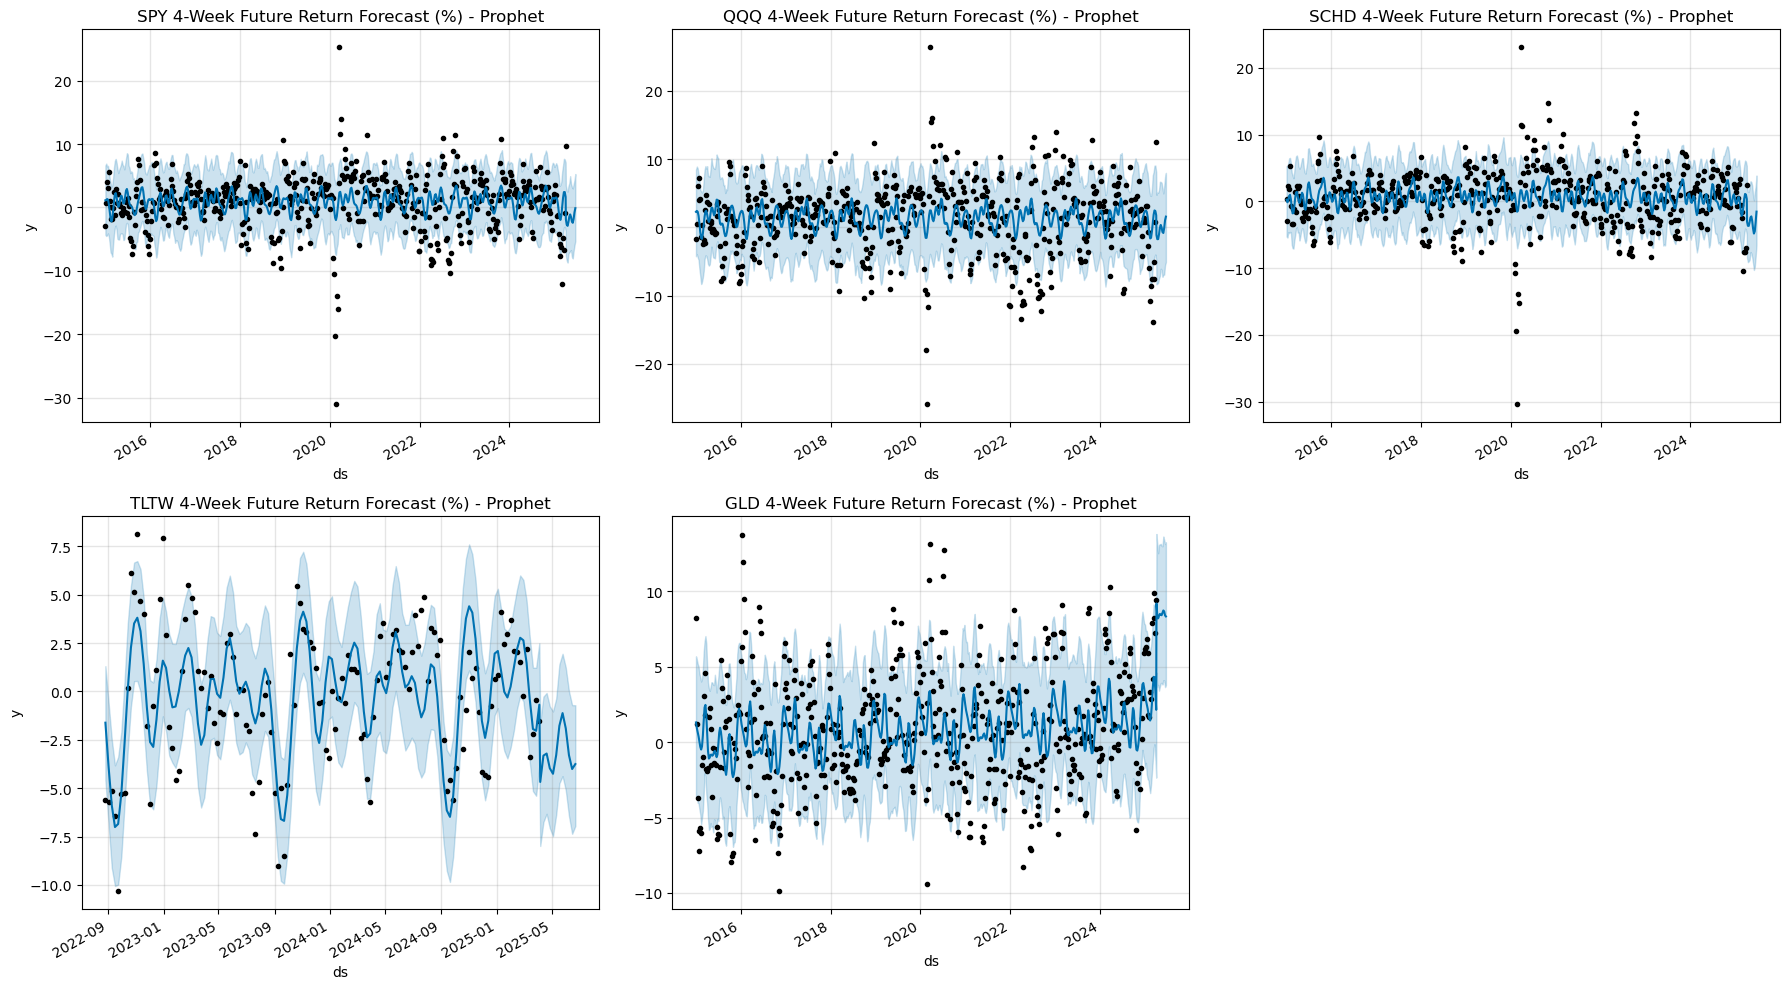

In [15]:
# 2. Forecasting ETF return using Prophet Modeling
from prophet import Prophet

# === 2.1 Load dataset ===
full_data = pd.read_csv('01_data/processed/etf_full_features_weekly.csv', index_col=0, parse_dates=True)
etfs = ['SPY', 'QQQ', 'SCHD', 'TLTW','GLD']

# === 2.2 Create scaled 4-week future returns (%)
# 4 week return used for better modelling
for ticker in etfs:
    full_data[f'{ticker}_future_return_4w'] = (full_data[ticker].shift(-4) - full_data[ticker]) / full_data[ticker] * 100

print(" 4-week future returns (% scale) created.")

# === 2.3 Create folder to save forecasts ===
os.makedirs('01_data/forecasts_prophet', exist_ok=True)

import matplotlib.pyplot as plt

# ===2.4 Create subplot layout: 2 rows, 3 columns ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# === 2.5 Loop through ETFs and forecast ===
for idx, ticker in enumerate(etfs):
    print(f"\n Training Prophet for {ticker}...")

    # Prepare data
    df = pd.DataFrame({
        'ds': full_data.index,
        'y': full_data[f'{ticker}_future_return_4w']
    }).dropna()

    # Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    model.fit(df)

    # Forecast
    future = model.make_future_dataframe(periods=12, freq='W')
    forecast = model.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(
        f'01_data/forecasts_prophet/{ticker}_4w_forecast.csv', index=False)

    # Plot on subplot
    model.plot(forecast, ax=axes[idx])
    axes[idx].set_title(f'{ticker} 4-Week Future Return Forecast (%) - Prophet')

# Hide unused last subplot if ETFs < 6
if len(etfs) < len(axes):
    for j in range(len(etfs), len(axes)):
        fig.delaxes(axes[j])
for ax in axes:
    if ax in fig.axes:  # ensure it's a valid axis
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment('right')
plt.tight_layout()
plt.show()



 Training Prophet model for SPY 4-week returns...


17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing



 Training Prophet model for QQQ 4-week returns...


17:31:21 - cmdstanpy - INFO - Chain [1] done processing



 Training Prophet model for SCHD 4-week returns...


17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:22 - cmdstanpy - INFO - Chain [1] start processing



 Training Prophet model for TLTW 4-week returns...


17:31:22 - cmdstanpy - INFO - Chain [1] done processing



 Training Prophet model for GLD 4-week returns...


17:31:22 - cmdstanpy - INFO - Chain [1] start processing
17:31:22 - cmdstanpy - INFO - Chain [1] done processing


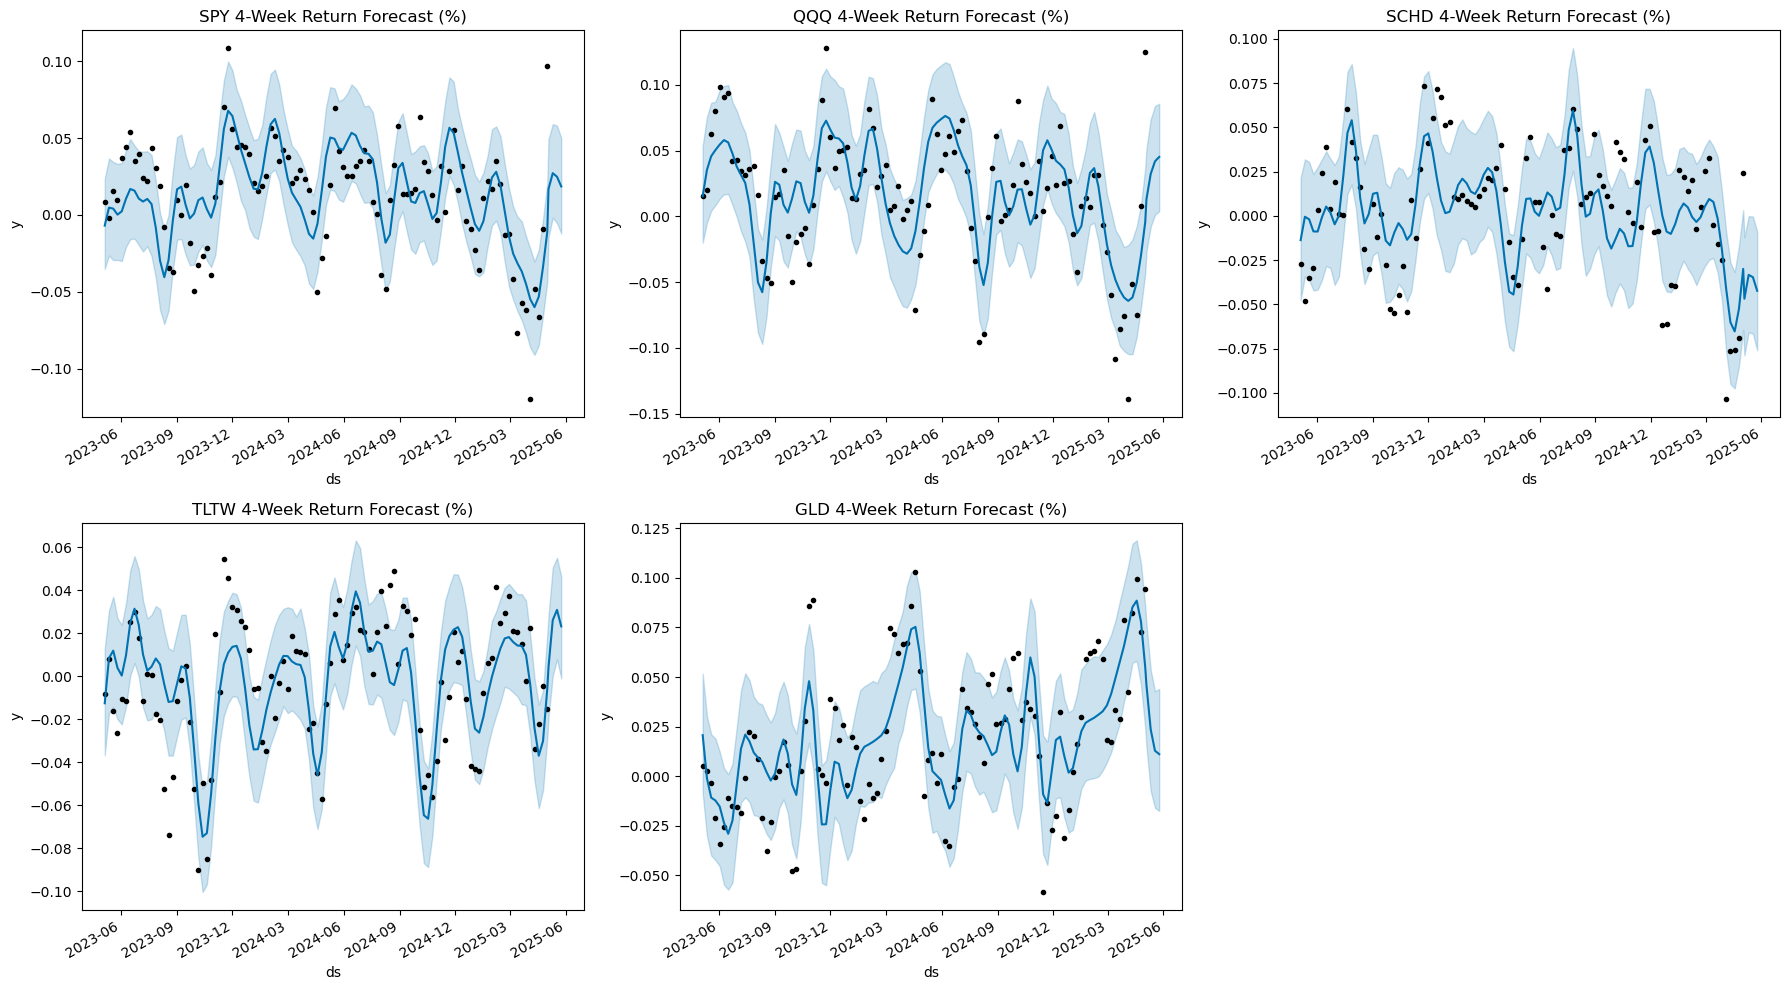


 All ETF 4-week returns predicted and plotted successfully!


In [17]:
# === 3.1 Define ETFs and Macro Features ===
etfs = ['SPY', 'QQQ', 'SCHD', 'TLTW', 'GLD']
macro_features = ['fed_rate']
forecast_horizon = 4  # Forecast for 4 weeks

# === 3.2 Define ETF-specific parameters ===
etf_params = {
    'SPY': {'changepoint_prior_scale': 0.8, 'training_period_months': 24},
    'QQQ': {'changepoint_prior_scale': 0.8, 'training_period_months': 24},
    'SCHD': {'changepoint_prior_scale': 0.25, 'training_period_months': 24},
    'TLTW': {'changepoint_prior_scale': 0.2, 'training_period_months': 24},
    'GLD': {'changepoint_prior_scale': 0.15, 'training_period_months': 24}
}

# === 3.3 Load Full Data ===
full_data = pd.read_csv('01_data/processed/etf_full_features_weekly.csv', index_col=0, parse_dates=True)

# === 3.4. Calculate 4-week returns for each ETF ===
for ticker in etfs:
    full_data[f'{ticker}_4wk_return'] = full_data[ticker].pct_change(periods=4)

# === Create folder to save forecasts ===
os.makedirs('01_data/forecasts_prophet_final', exist_ok=True)

# === Setup for subplot figure ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# === 3.5 Train Prophet Model and Plot ===
for idx, ticker in enumerate(etfs):
    print(f"\n Training Prophet model for {ticker} 4-week returns...")

    changepoint_prior_scale = etf_params[ticker]['changepoint_prior_scale']
    training_period_months = etf_params[ticker]['training_period_months']

    end_date = full_data.index.max()
    start_date = end_date - pd.DateOffset(months=training_period_months)

    df = full_data[start_date:end_date][[f'{ticker}_4wk_return']]
    macro_data_filtered = full_data[start_date:end_date][macro_features]

    df_reset = df.reset_index()
    macro_data_filtered_reset = macro_data_filtered.reset_index()

    df_reset.rename(columns={df_reset.columns[0]: 'ds'}, inplace=True)
    macro_data_filtered_reset.rename(columns={macro_data_filtered_reset.columns[0]: 'ds'}, inplace=True)

    df = pd.DataFrame({
        'ds': df_reset['ds'],
        'y': df_reset[f'{ticker}_4wk_return']
    })

    for feature in macro_features:
        df[feature] = macro_data_filtered_reset[feature]

    df = df.dropna(subset=['y'])
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=changepoint_prior_scale
    )

    for feature in macro_features:
        model.add_regressor(feature)

    model.fit(df)

    future = model.make_future_dataframe(periods=forecast_horizon, freq='W')
    future['fed_rate'] = 4.375  # Static macro feature for forecast

    forecast = model.predict(future)

    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(
        f'01_data/forecasts_prophet_final/{ticker}_4wk_return_forecast.csv', index=False
    )

    # Plot on subplot axis
    model.plot(forecast, ax=axes[idx])
    axes[idx].set_title(f'{ticker} 4-Week Return Forecast (%)')
    axes[idx].grid()

# Remove any unused subplot axes
if len(etfs) < len(axes):
    for j in range(len(etfs), len(axes)):
        fig.delaxes(axes[j])
for ax in axes:
    if ax in fig.axes:  # ensure it's a valid axis
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment('right')
plt.tight_layout()
plt.show()

print("\n All ETF 4-week returns predicted and plotted successfully!")


In [53]:
# 4.Comparing prophet model vs optimized prophet model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
# === 4.1 Data Preparations ===
etfs = ['SPY', 'QQQ', 'SCHD', 'TLTW','GLD']

# Load full actual price data
full_data = pd.read_csv('01_data/processed/etf_full_features_weekly.csv', index_col=0, parse_dates=True)

# Initialize results list
results = []

for ticker in etfs:
    print(f"\n Evaluating {ticker}...")

 # === 4.2. Load Forecasts ===
    # Improved model (with macro, tuned parameters)
    improved_forecast = pd.read_csv(f'01_data/forecasts_prophet_final/{ticker}_4wk_return_forecast.csv', parse_dates=['ds'])
    
    # Baseline model (simple Prophet without macro, default param)
    baseline_forecast = pd.read_csv(f'01_data/forecasts_prophet/{ticker}_4w_forecast.csv', parse_dates=['ds'])

# === 4.3. Prepare Actual 4-week Returns ===
    actual_prices = full_data[[ticker]].copy().reset_index()

    # Calculate actual 4-week returns (%)
    actual_prices['actual_4wk_return'] = (actual_prices[ticker].shift(-4) - actual_prices[ticker]) / actual_prices[ticker] * 100

    # Prepare actual returns
    actual_returns = actual_prices[['Date', 'actual_4wk_return']].rename(columns={'Date': 'ds'})

# === 4.4 Merge forecasts with actual returns ===
    df_baseline = pd.merge(baseline_forecast, actual_returns, on='ds', how='inner')
    df_improved = pd.merge(improved_forecast, actual_returns, on='ds', how='inner')

    # Drop NaN
    df_baseline = df_baseline.dropna()
    df_improved = df_improved.dropna()

 # === 4.5. Calculate Metrics ===
    # Baseline
    baseline_mape = np.mean(np.abs((df_baseline['actual_4wk_return'] - df_baseline['yhat']) / df_baseline['actual_4wk_return'])) * 100
    baseline_rmse = np.sqrt(mean_squared_error(df_baseline['actual_4wk_return'], df_baseline['yhat']))

    # Improved
    improved_mape = np.mean(np.abs((df_improved['actual_4wk_return'] - df_improved['yhat']) / df_improved['actual_4wk_return'])) * 100
    improved_rmse = np.sqrt(mean_squared_error(df_improved['actual_4wk_return'], df_improved['yhat']))

    # Calculate Improvements
    mape_improvement = (baseline_mape - improved_mape) / baseline_mape * 100
    rmse_improvement = (baseline_rmse - improved_rmse) / baseline_rmse * 100

# 4.6. Save results
    results.append({
        'Ticker': ticker,
        'Baseline MAPE (%)': round(baseline_mape, 2),
        'Improved MAPE (%)': round(improved_mape, 2),
        'MAPE Improvement (%)': round(mape_improvement, 2),
        'Baseline RMSE': round(baseline_rmse, 4),
        'Improved RMSE': round(improved_rmse, 4),
        'RMSE Improvement (%)': round(rmse_improvement, 2)
    })

# === 4.7. Create Results Table ===
results_df = pd.DataFrame(results)

# === Fancy Table Styling ===
def red_green_gradient(val):
    if val > 0:
        color = f'background: linear-gradient(90deg, rgba(0,200,0,{min(abs(val)/20, 1)}) {abs(val)}%, transparent {abs(val)}%)'
    else:
        color = f'background: linear-gradient(90deg, rgba(200,0,0,{min(abs(val)/20, 1)}) {abs(val)}%, transparent {abs(val)}%)'
    return color

styled_table = results_df.style\
    .set_caption("📊 Model Accuracy Comparison – MAPE & RMSE Improvements")\
    .format({
        'Baseline MAPE (%)': '{:.2f}%',
        'Improved MAPE (%)': '{:.2f}%',
        'MAPE Improvement (%)': '{:+.2f}%',
        'Baseline RMSE': '{:.4f}',
        'Improved RMSE': '{:.4f}',
        'RMSE Improvement (%)': '{:+.2f}%'
    })\
    .applymap(red_green_gradient, subset=['MAPE Improvement (%)', 'RMSE Improvement (%)'])



# === Save raw DataFrame to CSV (not styled Excel here)
results_df.to_csv('01_data/processed/model_comparison_results.csv', index=False)
# === Display styled table in Jupyter
styled_table


 Evaluating SPY...

 Evaluating QQQ...

 Evaluating SCHD...

 Evaluating TLTW...

 Evaluating GLD...


C:\Users\user\AppData\Local\Temp\ipykernel_2888\3993807903.py:85: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,Ticker,Baseline MAPE (%),Improved MAPE (%),MAPE Improvement (%),Baseline RMSE,Improved RMSE,RMSE Improvement (%)
0,SPY,196.18%,98.19%,+49.95%,4.2069,3.9139,+6.96%
1,QQQ,261.13%,99.62%,+61.85%,5.1246,5.1007,+0.47%
2,SCHD,197.98%,99.75%,+49.61%,4.1183,3.5335,+14.20%
3,TLTW,1001.57%,122.88%,+87.73%,2.4868,3.0874,-24.15%
4,GLD,169.94%,98.91%,+41.80%,3.6193,4.1505,-14.68%


In [55]:
#5.1 Simulating Porfolio 1- Lump Sum 
# === Load ETF Prices ===
prices = pd.read_csv('01_data/processed/etf_full_features_weekly.csv', index_col=0, parse_dates=True)
prices = prices[['SPY', 'QQQ', 'SCHD', 'TLTW','GLD']]
etfs = prices.columns.tolist()

# === 5.1.1 Set Initial Investment Parameters ===
initial_investment = 48000
allocation = {etf: initial_investment * 0.20 for etf in etfs}

# === 5.1.2 Find First Investment Date ===
first_invest_date = prices.loc['2022-09-01':].index[0]
initial_prices = prices.loc[first_invest_date]

# === 5.1.3 Buy ETF Units Once ===
units = {etf: allocation[etf] / initial_prices[etf] for etf in etfs}

# === 5.1.4 Simulate Weekly Portfolio Value ===
weekly_index = prices.loc[first_invest_date:].index
lump_sum_holdings = pd.DataFrame(index=weekly_index, columns=etfs)

# Constant holdings throughout
for etf in etfs:
    lump_sum_holdings[etf] = units[etf]

# Calculate portfolio value
portfolio_value = (lump_sum_holdings * prices.loc[weekly_index]).sum(axis=1)
portfolio_df1 = pd.DataFrame({
    'Portfolio Value': portfolio_value,
    'Total Invested': initial_investment,
    'Cumulative Return': portfolio_value.pct_change().fillna(0).add(1).cumprod() - 1
})
portfolio_df1

,Portfolio Value,Total Invested,Cumulative Return
Date,,,
2022-09-02,48000.000000,48000,0.000000
2022-09-09,48924.015544,48000,0.019250
2022-09-16,47129.531626,48000,-0.018135
2022-09-23,45662.710082,48000,-0.048694
2022-09-30,44793.099004,48000,-0.066810
...,...,...,...
2025-04-04,63563.823563,48000,0.324246
2025-04-11,65984.221135,48000,0.374671
2025-04-18,66123.985749,48000,0.377583


In [59]:
#5.2. Lump Sum with best allocation strategy(with higest Sharpe Ratio)
# === 5.2.1 Load ETF Prices and Returns ===
prices = pd.read_csv('01_data/processed/etf_full_features_weekly.csv', index_col=0, parse_dates=True)
etfs = ['SPY', 'QQQ', 'SCHD', 'TLTW','GLD']
prices = prices[etfs]
prices = prices[prices.index >= '2022-09-01']
returns = prices.pct_change().dropna()
downside = returns.copy()
downside[downside > 0] = 0

# === 5.2.2 Generate Random Portfolios (10% ≤ weight ≤ 30%) ===
num_portfolios = 48000
valid_portfolios = []

np.random.seed(42)
while len(valid_portfolios) < num_portfolios:
    weights = np.random.dirichlet(np.ones(len(etfs)))
    if all((weights >= 0.10) & (weights <= 0.30)):
        valid_portfolios.append(weights)

# === 5.2.3 Evaluate Each Portfolio (Assuming no fed rate influences, for simplifications) ===
results = []
for weights in valid_portfolios:
    port_return = np.sum(returns.mean() * weights) * 52
    port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 52, weights)))
    downside_std = np.sqrt((downside.var() * 52).dot(weights ** 2))
    sharpe = port_return / port_vol if port_vol > 0 else 0
    sortino = port_return / downside_std if downside_std > 0 else 0
    results.append({
        'Weights': weights,
        'Return': port_return,
        'Volatility': port_vol,
        'Sharpe': sharpe,
        'Sortino': sortino
    })

# === 5.2.4 Choose Best by Sharpe Ratio ===
df_results = pd.DataFrame(results)
best = df_results.loc[df_results['Sharpe'].idxmax()]
best_weights = dict(zip(etfs, best['Weights']))

# === 5.2.5 Rebuild Portfolio Using Best Weights ===
initial_investment = 48000
first_date = prices.index[0]
initial_prices = prices.loc[first_date]
alloc = {etf: initial_investment * best_weights[etf] for etf in etfs}
units = {etf: alloc[etf] / initial_prices[etf] for etf in etfs}

# === 5.2.6 Simulate Portfolio ===
holdings = pd.DataFrame(index=prices.index, columns=etfs)
for etf in etfs:
    holdings[etf] = units[etf]
portfolio_value = (holdings * prices).sum(axis=1)
portfolio_df7 = pd.DataFrame({
    'Portfolio Value': portfolio_value,
    'Total Invested': initial_investment,
    'Cumulative Return': portfolio_value.pct_change().fillna(0).add(1).cumprod() - 1
})
# === Show Final Allocations ===
print("\n Optimized Allocation (10%-40% Constraint):")
for etf, weight in best_weights.items():
    print(f"{etf}: {weight * 100:.2f}%")
portfolio_df7


 Optimized Allocation (10%-40% Constraint):
SPY: 29.20%
QQQ: 19.01%
SCHD: 10.96%
TLTW: 10.91%
GLD: 29.92%


,Portfolio Value,Total Invested,Cumulative Return
Date,,,
2022-09-02,48000.000000,48000,0.000000
2022-09-09,49015.274169,48000,0.021152
2022-09-16,47137.801306,48000,-0.017962
2022-09-23,45603.519185,48000,-0.049927
2022-09-30,44872.772122,48000,-0.065151
...,...,...,...
2025-04-04,68163.774844,48000,0.420079
2025-04-11,71620.538096,48000,0.492095
2025-04-18,71852.571182,48000,0.496929


In [61]:
#5.3 DCA without Rebalancing
# === 5.3.1 Load ETF Prices ===
prices = pd.read_csv('01_data/processed/etf_full_features_weekly.csv', index_col=0, parse_dates=True)
prices = prices[['SPY', 'QQQ', 'SCHD', 'TLTW','GLD']]
etfs = prices.columns.tolist()

# === 5.3.2 DCA Setup ===
start_date = '2022-09-01'
investment_amount = 1500
investment_per_etf = investment_amount / len(etfs)

# === 5.3.3 Build Investment Calendar ===
investment_dates = []
months = prices.index.to_period('M').unique()
for month in months:
    month_data = prices[month.start_time:month.end_time]
    fridays = month_data[month_data.index.weekday == 4]
    if not fridays.empty:
        investment_dates.append(fridays.index[-1])
investment_dates = pd.to_datetime(investment_dates)
investment_dates = investment_dates[investment_dates >= pd.to_datetime(start_date)]

# === 5.3.4 Initialize Holdings Table ===
weekly_index = prices.loc[investment_dates[0]:].index
holdings = pd.DataFrame(index=weekly_index, columns=etfs).fillna(0)
units = {etf: 0 for etf in etfs}
invested_tracker = pd.Series(0, index=weekly_index)

# === 5.3.5 Simulate Monthly DCA Purchases ===
total_invested = 0
for date in weekly_index:
    if date in investment_dates:
        total_invested += investment_amount
        for etf in etfs:
            units[etf] += investment_per_etf / prices.loc[date, etf]
    for etf in etfs:
        holdings.loc[date, etf] = units[etf]
    invested_tracker.loc[date] = total_invested
holdings = holdings.ffill()
invested_tracker = invested_tracker.ffill()

# === Calculate Portfolio Value Weekly ===
portfolio_value = (holdings * prices.loc[holdings.index]).sum(axis=1)

# === Corrected Cumulative Return ===
cumulative_return = (portfolio_value - invested_tracker) / invested_tracker

# === Create Final Portfolio Table ===
portfolio_df2 = pd.DataFrame({
    'Portfolio Value': portfolio_value,
    'Total Invested': invested_tracker,
    'Cumulative Return': cumulative_return
})
portfolio_df2.index.name = "Date"

# === Display Table Preview ===
portfolio_df2

C:\Users\user\AppData\Local\Temp\ipykernel_2888\1933573170.py:25: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\user\AppData\Local\Temp\ipykernel_2888\1933573170.py:37: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8701914033367782' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\user\AppData\Local\Temp\ipykernel_2888\1933573170.py:37: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.141396427191392' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\user\AppData\Local\Temp\ipykernel_2888\1933573170.py

,Portfolio Value,Total Invested,Cumulative Return
Date,,,
2022-09-30,1500.000000,1500,0.000000
2022-10-07,1515.383518,1500,0.010256
2022-10-14,1486.955207,1500,-0.008697
2022-10-21,1514.612419,1500,0.009742
2022-10-28,3058.689725,3000,0.019563
...,...,...,...
2025-04-04,52783.875816,46500,0.135137
2025-04-11,54511.199899,46500,0.172284
2025-04-18,54673.847223,46500,0.175782


In [63]:
#5.4 DCA Rebalancing based on propht forecast (monthly)
# === 5.4.1 Load Forecasts and Prices ===
etfs = ['SPY', 'QQQ', 'SCHD', 'TLTW','GLD']
forecast_dir = '01_data/forecasts_prophet_final/'
forecast_dict = {
    etf: pd.read_csv(f'{forecast_dir}{etf}_4wk_return_forecast.csv', parse_dates=['ds'])
    for etf in etfs
}

# Load ETF weekly prices
prices = pd.read_csv('01_data/processed/etf_full_features_weekly.csv', index_col=0, parse_dates=True)
prices = prices[etfs]

# === 5.4.2 Setup Parameters ===
start_date = '2022-09-01'
investment_amount = 1500

# === 5.4.3 Build Investment Calendar (Monthly Last Fridays) ===
investment_dates = []
months = prices.index.to_period('M').unique()
for month in months:
    fridays = prices[month.start_time:month.end_time]
    fridays = fridays[fridays.index.weekday == 4]
    if not fridays.empty:
        investment_dates.append(fridays.index[-1])
investment_dates = pd.to_datetime(investment_dates)
investment_dates = investment_dates[investment_dates >= pd.to_datetime(start_date)]

# === Weekly Index ===
weekly_index = prices.loc[investment_dates[0]:].index

# === 5.4.4 Initialize Portfolio ===
units = {etf: 0 for etf in etfs}
holdings = pd.DataFrame(index=weekly_index, columns=etfs).fillna(0)
invested_tracker = pd.Series(data=0.0, index=weekly_index)

# === 5.4.5 Forecast-based DCA Simulation ===
cumulative_investment = 0
for date in weekly_index:
    if date in investment_dates:
        # Forecast 4 weeks ahead
        forecast_date = date + pd.Timedelta(days=28)
        pred_returns = {}

        for etf in etfs:
            forecast_df = forecast_dict[etf].set_index('ds')
            try:
                forecast_row = forecast_df.loc[forecast_df.index >= forecast_date].iloc[0]
                pred_returns[etf] = forecast_row['yhat']
            except IndexError:
                pred_returns[etf] = 0

        # Convert returns to weights
        total_positive = sum(max(v, 0) for v in pred_returns.values())
        if total_positive > 0:
            weights = {etf: max(pred_returns[etf], 0) / total_positive for etf in etfs}
        else:
            weights = {etf: 1 / len(etfs) for etf in etfs}

        for etf in etfs:
            amount = investment_amount * weights[etf]
            units[etf] += amount / prices.loc[date, etf]

        # Log this month's new cumulative investment
        cumulative_investment += investment_amount
        invested_tracker.loc[date] = cumulative_investment

    # Update holdings snapshot
    for etf in etfs:
        holdings.loc[date, etf] = units[etf]

# === Fill gaps forward in investment tracker and holdings ===
holdings = holdings.ffill()
invested_tracker = invested_tracker.replace(0, np.nan).ffill()

# === Compute Portfolio Value Weekly ===
portfolio_value = (holdings * prices.loc[holdings.index]).sum(axis=1)

# === Compute Correct Cumulative Return ===
cumulative_return = (portfolio_value - invested_tracker) / invested_tracker

# === Combine Final Results ===
portfolio_df3 = pd.DataFrame({
    'Portfolio Value': portfolio_value,
    'Total Invested': invested_tracker,
    'Cumulative Return': cumulative_return
})
portfolio_df3.index.name = 'Date'

# === Output Check ===
portfolio_df3.round(4) # Show head for early rows

C:\Users\user\AppData\Local\Temp\ipykernel_2888\292186337.py:34: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\user\AppData\Local\Temp\ipykernel_2888\292186337.py:70: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.421716781007688' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\user\AppData\Local\Temp\ipykernel_2888\292186337.py:70: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.582762072326273' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\user\AppData\Local\Temp\ipykernel_2888\292186337.py:70: 

,Portfolio Value,Total Invested,Cumulative Return
Date,,,
2022-09-30,1500.0000,1500.0,-0.0000
2022-10-07,1522.3028,1500.0,0.0149
2022-10-14,1475.0370,1500.0,-0.0166
2022-10-21,1516.5311,1500.0,0.0110
2022-10-28,3024.8177,3000.0,0.0083
...,...,...,...
2025-04-04,57472.8773,46500.0,0.2360
2025-04-11,60730.2358,46500.0,0.3060
2025-04-18,61066.1739,46500.0,0.3133


In [65]:
#5.4 DCA Rebalancing based on propht forecast ( every 2 months)
# === 5.4.1  Load Forecasts and Prices ===
etfs = ['SPY', 'QQQ', 'SCHD', 'TLTW','GLD']
forecast_dir = '01_data/forecasts_prophet_final/'
forecast_dict = {
    etf: pd.read_csv(f'{forecast_dir}{etf}_4wk_return_forecast.csv', parse_dates=['ds'])
    for etf in etfs
}

# Load ETF prices
prices = pd.read_csv('01_data/processed/etf_full_features_weekly.csv', index_col=0, parse_dates=True)
prices = prices[etfs]

# === 5.4.2 Setup ===
start_date = '2022-09-01'
investment_amount = 3000  # Every 2 months

# Generate 2-month rebalancing calendar (last Friday every 2 months)
investment_dates = []
months = prices.index.to_period('M').unique()
selected_months = months[::2]  # Every 2 months
for month in selected_months:
    fridays = prices[month.start_time:month.end_time]
    fridays = fridays[fridays.index.weekday == 4]
    if not fridays.empty:
        investment_dates.append(fridays.index[-1])
investment_dates = pd.to_datetime(investment_dates)
investment_dates = investment_dates[investment_dates >= pd.to_datetime(start_date)]

# Weekly tracking dates
weekly_index = prices.loc[investment_dates[0]:].index

# === 5.4.3 Initialize Portfolio ===
units = {etf: 0 for etf in etfs}
holdings = pd.DataFrame(index=weekly_index, columns=etfs).fillna(0)
invested_tracker = pd.Series(data=0.0, index=weekly_index)

# === 5.4.4 Simulation ===
cumulative_investment = 0
for date in weekly_index:
    if date in investment_dates:
        forecast_date = date + pd.Timedelta(days=28)
        pred_returns = {}
        for etf in etfs:
            forecast_df = forecast_dict[etf].set_index('ds')
            try:
                forecast_row = forecast_df.loc[forecast_df.index >= forecast_date].iloc[0]
                pred_returns[etf] = forecast_row['yhat']
            except IndexError:
                pred_returns[etf] = 0

        total_positive = sum(max(v, 0) for v in pred_returns.values())
        if total_positive > 0:
            weights = {etf: max(pred_returns[etf], 0) / total_positive for etf in etfs}
        else:
            weights = {etf: 1 / len(etfs) for etf in etfs}

        for etf in etfs:
            amount = investment_amount * weights[etf]
            units[etf] += amount / prices.loc[date, etf]

        cumulative_investment += investment_amount
        invested_tracker.loc[date] = cumulative_investment

    for etf in etfs:
        holdings.loc[date, etf] = units[etf]

holdings = holdings.ffill()
invested_tracker = invested_tracker.replace(0, np.nan).ffill()

# === Calculate Portfolio ===
portfolio_value = (holdings * prices.loc[holdings.index]).sum(axis=1)
cumulative_return = (portfolio_value - invested_tracker) / invested_tracker

# === Combine Results ===
portfolio_df4 = pd.DataFrame({
    'Portfolio Value': portfolio_value,
    'Total Invested': invested_tracker,
    'Cumulative Return': cumulative_return
})
portfolio_df4.index.name = 'Date'

portfolio_df4.round(4)

C:\Users\user\AppData\Local\Temp\ipykernel_2888\2089517966.py:35: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\user\AppData\Local\Temp\ipykernel_2888\2089517966.py:66: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.843433562015376' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\user\AppData\Local\Temp\ipykernel_2888\2089517966.py:66: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.165524144652546' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\user\AppData\Local\Temp\ipykernel_2888\2089517966.py

,Portfolio Value,Total Invested,Cumulative Return
Date,,,
2022-09-30,3000.0000,3000.0,-0.0000
2022-10-07,3044.6056,3000.0,0.0149
2022-10-14,2950.0739,3000.0,-0.0166
2022-10-21,3033.0623,3000.0,0.0110
2022-10-28,3049.6353,3000.0,0.0165
...,...,...,...
2025-04-04,59289.3074,48000.0,0.2352
2025-04-11,62789.7463,48000.0,0.3081
2025-04-18,63204.1551,48000.0,0.3168


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load Forecasts and Prices ===
etfs = ['SPY', 'QQQ', 'SCHD', 'TLTW','GLD']
forecast_dir = '01_data/forecasts_prophet_final/'
forecast_dict = {
    etf: pd.read_csv(f'{forecast_dir}{etf}_4wk_return_forecast.csv', parse_dates=['ds'])
    for etf in etfs
}

# Load ETF prices
prices = pd.read_csv('01_data/processed/etf_full_features_weekly.csv', index_col=0, parse_dates=True)
prices = prices[etfs]

# === Setup ===
start_date = '2022-09-01'
investment_amount = 6000  # Every 4 months

# Generate 4-month rebalancing calendar (last Friday every 4 months)
investment_dates = []
months = prices.index.to_period('M').unique()
selected_months = months[::4]  # Every 4 months
for month in selected_months:
    fridays = prices[month.start_time:month.end_time]
    fridays = fridays[fridays.index.weekday == 4]
    if not fridays.empty:
        investment_dates.append(fridays.index[-1])
investment_dates = pd.to_datetime(investment_dates)
investment_dates = investment_dates[investment_dates >= pd.to_datetime(start_date)]

# Weekly tracking dates
weekly_index = prices.loc[investment_dates[0]:].index

# === Initialize Portfolio ===
units = {etf: 0 for etf in etfs}
holdings = pd.DataFrame(index=weekly_index, columns=etfs).fillna(0)
invested_tracker = pd.Series(data=0.0, index=weekly_index)

# === Simulation ===
cumulative_investment = 0
for date in weekly_index:
    if date in investment_dates:
        forecast_date = date + pd.Timedelta(days=28)
        pred_returns = {}
        for etf in etfs:
            forecast_df = forecast_dict[etf].set_index('ds')
            try:
                forecast_row = forecast_df.loc[forecast_df.index >= forecast_date].iloc[0]
                pred_returns[etf] = forecast_row['yhat']
            except IndexError:
                pred_returns[etf] = 0

        total_positive = sum(max(v, 0) for v in pred_returns.values())
        if total_positive > 0:
            weights = {etf: max(pred_returns[etf], 0) / total_positive for etf in etfs}
        else:
            weights = {etf: 1 / len(etfs) for etf in etfs}

        for etf in etfs:
            amount = investment_amount * weights[etf]
            units[etf] += amount / prices.loc[date, etf]

        cumulative_investment += investment_amount
        invested_tracker.loc[date] = cumulative_investment

    for etf in etfs:
        holdings.loc[date, etf] = units[etf]

holdings = holdings.ffill()
invested_tracker = invested_tracker.replace(0, np.nan).ffill()

# === Calculate Portfolio ===
portfolio_value = (holdings * prices.loc[holdings.index]).sum(axis=1)
cumulative_return = (portfolio_value - invested_tracker) / invested_tracker

# === Combine Results ===
portfolio_df5 = pd.DataFrame({
    'Portfolio Value': portfolio_value,
    'Total Invested': invested_tracker,
    'Cumulative Return': cumulative_return
})
portfolio_df5.index.name = 'Date'

portfolio_df5.round(4)

C:\Users\user\AppData\Local\Temp\ipykernel_2888\919394136.py:38: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\user\AppData\Local\Temp\ipykernel_2888\919394136.py:69: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.686867124030751' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\user\AppData\Local\Temp\ipykernel_2888\919394136.py:69: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22.33104828930509' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\user\AppData\Local\Temp\ipykernel_2888\919394136.py:69: 

,Portfolio Value,Total Invested,Cumulative Return
Date,,,
2022-09-30,6000.0000,6000.0,-0.0000
2022-10-07,6089.2113,6000.0,0.0149
2022-10-14,5900.1478,6000.0,-0.0166
2022-10-21,6066.1245,6000.0,0.0110
2022-10-28,6099.2707,6000.0,0.0165
...,...,...,...
2025-04-04,61853.8709,48000.0,0.2886
2025-04-11,65189.7709,48000.0,0.3581
2025-04-18,65809.2736,48000.0,0.3710


In [69]:
#5.6 DCA Rebalancing based on propht forecast ( every 6 months)
# === 5.6.1 Load Forecasts and Prices ===
etfs = ['SPY', 'QQQ', 'SCHD', 'TLTW','GLD']
forecast_dir = '01_data/forecasts_prophet_final/'
forecast_dict = {
    etf: pd.read_csv(f'{forecast_dir}{etf}_4wk_return_forecast.csv', parse_dates=['ds'])
    for etf in etfs
}

# Load ETF prices
prices = pd.read_csv('01_data/processed/etf_full_features_weekly.csv', index_col=0, parse_dates=True)
prices = prices[etfs]

# === 5.6.2 Setup ===
start_date = '2022-09-01'
investment_amount = 9000  # Every 6 months

# Generate 6-month rebalancing calendar (last Friday every 6 months)
investment_dates = []
months = prices.index.to_period('M').unique()
selected_months = months[::6]  # Every 6 months
for month in selected_months:
    fridays = prices[month.start_time:month.end_time]
    fridays = fridays[fridays.index.weekday == 4]
    if not fridays.empty:
        investment_dates.append(fridays.index[-1])
investment_dates = pd.to_datetime(investment_dates)
investment_dates = investment_dates[investment_dates >= pd.to_datetime(start_date)]

# Weekly tracking dates
weekly_index = prices.loc[investment_dates[0]:].index

# === 5.6.3 Initialize Portfolio ===
units = {etf: 0 for etf in etfs}
holdings = pd.DataFrame(index=weekly_index, columns=etfs).fillna(0)
invested_tracker = pd.Series(data=0.0, index=weekly_index)

# === 5.6.4 Simulation ===
cumulative_investment = 0
for date in weekly_index:
    if date in investment_dates:
        forecast_date = date + pd.Timedelta(days=28)
        pred_returns = {}
        for etf in etfs:
            forecast_df = forecast_dict[etf].set_index('ds')
            try:
                forecast_row = forecast_df.loc[forecast_df.index >= forecast_date].iloc[0]
                pred_returns[etf] = forecast_row['yhat']
            except IndexError:
                pred_returns[etf] = 0

        total_positive = sum(max(v, 0) for v in pred_returns.values())
        if total_positive > 0:
            weights = {etf: max(pred_returns[etf], 0) / total_positive for etf in etfs}
        else:
            weights = {etf: 1 / len(etfs) for etf in etfs}

        for etf in etfs:
            amount = investment_amount * weights[etf]
            units[etf] += amount / prices.loc[date, etf]

        cumulative_investment += investment_amount
        invested_tracker.loc[date] = cumulative_investment

    for etf in etfs:
        holdings.loc[date, etf] = units[etf]

holdings = holdings.ffill()
invested_tracker = invested_tracker.replace(0, np.nan).ffill()

# === Calculate Portfolio ===
portfolio_value = (holdings * prices.loc[holdings.index]).sum(axis=1)
cumulative_return = (portfolio_value - invested_tracker) / invested_tracker

# === Combine Results ===
portfolio_df6 = pd.DataFrame({
    'Portfolio Value': portfolio_value,
    'Total Invested': invested_tracker,
    'Cumulative Return': cumulative_return
})
portfolio_df6.index.name = 'Date'

portfolio_df6.round(4)

C:\Users\user\AppData\Local\Temp\ipykernel_2888\133631211.py:35: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\user\AppData\Local\Temp\ipykernel_2888\133631211.py:66: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '13.076667238353496' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\user\AppData\Local\Temp\ipykernel_2888\133631211.py:66: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '28.90812834358849' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\user\AppData\Local\Temp\ipykernel_2888\133631211.py:66:

,Portfolio Value,Total Invested,Cumulative Return
Date,,,
2023-01-27,9000.0000,9000.0,0.0000
2023-02-03,8961.3676,9000.0,-0.0043
2023-02-10,8874.9444,9000.0,-0.0139
2023-02-17,8833.0576,9000.0,-0.0185
2023-02-24,8628.9199,9000.0,-0.0412
...,...,...,...
2025-04-04,52981.5854,45000.0,0.1774
2025-04-11,55747.7447,45000.0,0.2388
2025-04-18,56002.3362,45000.0,0.2445


In [151]:
#6. Evaluating generated Portfolio

# === 6.1 Rename and use final result DataFrames from prior steps ===
lump_sum_df = portfolio_df1.copy()
lump_allocation_optimized=portfolio_df7.copy()
dca_equal_df = portfolio_df2.copy()
dca_forecast_df = portfolio_df3.copy()
dca_forecast2months_df = portfolio_df4.copy()
dca_forecast4months_df = portfolio_df5.copy()
dca_forecast6months_df = portfolio_df6.copy()

# Add Total Invested for lump sum (fixed amount)
lump_sum_df['Total Invested'] = 48000
lump_allocation_optimized['Total Invested'] = 48000

# === 6.2 Corrected Metrics Function ===
def calculate_metrics(df, label, full_data):
    df = df.copy()
    df['Portfolio Value'] = pd.to_numeric(df['Portfolio Value'], errors='coerce')
    df['Total Invested'] = pd.to_numeric(df['Total Invested'], errors='coerce')

    # === Total Return ===
    total_return = (df['Portfolio Value'].iloc[-1] - df['Total Invested'].iloc[-1]) / df['Total Invested'].iloc[-1]

    # === Max Drawdown ===
    peak = df['Portfolio Value'].cummax()
    drawdown = (df['Portfolio Value'] - peak) / peak
    max_drawdown = drawdown.min()

    # === Lump Sum or DCA ===
    is_lump_sum = df['Total Invested'].nunique() == 1

    # === Trim first 6 months ===
    df_cut = df[df.index >= df.index[0] + pd.DateOffset(months=6)].copy()
    full_cut = full_data.loc[df_cut.index].copy()  # align full_data to df_cut

    # === Return Series ===
    if is_lump_sum:
        ret_cut = df_cut['Portfolio Value'].pct_change().dropna()
    else:
        df_cut['unit_price'] = df_cut['Portfolio Value'] / df_cut['Total Invested']
        ret_cut = df_cut['unit_price'].pct_change().dropna()

    # Align fed_rate to return dates, convert to decimal
    rf_weekly = full_cut['fed_rate'].loc[ret_cut.index] / 100

    # === Annualized values ===
    vol = ret_cut.std()
    annual_volatility = vol * np.sqrt(52)
    annual_return = ret_cut.mean() * 52 if len(ret_cut) > 2 else np.nan
    annual_rf = rf_weekly.mean() 

    # === Sharpe Ratio (based on annual return - annual risk free) ===
    sharpe = (annual_return - annual_rf) / annual_volatility if annual_volatility > 0 else np.nan

    # === Sortino Ratio (weekly downside deviation) ===
    downside = ret_cut[ret_cut < 0]
    downside_std = downside.std()
    sortino = ((annual_return - annual_rf) / (downside_std * np.sqrt(52))) if downside_std > 0 else np.nan

    return {
        'Strategy': label,
        'Total Return (%)': round(total_return * 100, 2),
        'Annual Return (%)': round(annual_return * 100, 2) if pd.notnull(annual_return) else np.nan,
        'Annual Volatility (%)': round(annual_volatility * 100, 2),
        'Max Drawdown (%)': round(max_drawdown * 100, 2),
        'Sharpe Ratio': round(sharpe, 2),
        'Sortino Ratio': round(sortino, 2)
    }

# === 6.2.1Compute All ===
results = [
    calculate_metrics(lump_sum_df, 'Lump Sum',full_data),
    calculate_metrics(lump_allocation_optimized, 'Lump Sum Optimized',full_data),
    calculate_metrics(dca_equal_df, 'DCA Equal',full_data),
    calculate_metrics(dca_forecast_df, 'DCA Forecast-Based',full_data),
    calculate_metrics(dca_forecast2months_df, 'DCA Forecast-Based (2 Months)',full_data),
    calculate_metrics(dca_forecast4months_df, 'DCA Forecast-Based (4 Months)',full_data),
    calculate_metrics(dca_forecast6months_df, 'DCA Forecast-Based (6 Months)',full_data)
    
]

# === 6.3 Final Comparison Table ===
metrics_df = pd.DataFrame(results).set_index('Strategy')

# === 6.4 Saving Results ===
metrics_df.to_csv('01_data/processed/model_comparison_results.csv', index=True)
lump_sum_df.to_csv('01_data/processed/lump_sum.csv', index=True)
lump_allocation_optimized.to_csv('01_data/processed/lump_allocation_optimized.csv', index=True)
dca_equal_df.to_csv('01_data/processed/dca_equal.csv', index=True)
dca_forecast_df.to_csv('01_data/processed/dca_forecast.csv', index=True)
dca_forecast2months_df .to_csv('01_data/processed/dca_forecast_2months.csv', index=True)
dca_forecast4months_df .to_csv('01_data/processed/dca_forecast_4months.csv', index=True)
dca_forecast6months_df .to_csv('01_data/processed/dca_forecast_6months.csv', index=True)
# === 6.5 Display ===
# Update strategy names to include emoji
metrics_df = metrics_df.rename(index={
    'Lump Sum Optimized': 'Lump Sum Optimized ✅',
    'DCA Forecast-Based (2 Months)': 'DCA Forecast-Based (2 Months) ⭐'
})

# === Highlight Best Sharpe/Sortino Only with Color ===
def highlight_best_text(row):
    styles = [''] * len(row)
    idx = metrics_df.columns

    is_lump = 'Lump' in row.name
    is_dca = 'DCA' in row.name

    max_sharpe_lump = metrics_df.loc[metrics_df.index.str.contains('Lump'), 'Sharpe Ratio'].max()
    max_sortino_lump = metrics_df.loc[metrics_df.index.str.contains('Lump'), 'Sortino Ratio'].max()
    max_sharpe_dca = metrics_df.loc[metrics_df.index.str.contains('DCA'), 'Sharpe Ratio'].max()
    max_sortino_dca = metrics_df.loc[metrics_df.index.str.contains('DCA'), 'Sortino Ratio'].max()

    if is_lump:
        if row['Sharpe Ratio'] == max_sharpe_lump:
            styles[idx.get_loc('Sharpe Ratio')] = 'font-weight: Bold'; 'color: Green'
        if row['Sortino Ratio'] == max_sortino_lump:
            styles[idx.get_loc('Sortino Ratio')] = 'font-weight: Bold'; 'color: Green'
    elif is_dca:
        if row['Sharpe Ratio'] == max_sharpe_dca:
            styles[idx.get_loc('Sharpe Ratio')] = 'font-weight: Bold'; 'color: Green'
        if row['Sortino Ratio'] == max_sortino_dca:
            styles[idx.get_loc('Sortino Ratio')] = 'font-weight: Bold'; 'color: Green'
    return styles

# === Bold border for the chosen DCA strategy ===
def bold_border_final_choice(row):
    if '⭐' in row.name:
        return ['border: 2px solid black; font-weight: bold' for _ in row]
    return ['' for _ in row]

styled_metrics = metrics_df.style\
    .set_caption("📊 Portfolio Strategy Comparison – Clean Highlight View")\
    .format({
        "Total Return (%)": "{:.2f}%",
        "Annual Return (%)": "{:.2f}%",
        "Annual Volatility (%)": "{:.2f}%",
        "Max Drawdown (%)": "{:.2f}%",
        "Sharpe Ratio": "{:.2f}",
        "Sortino Ratio": "{:.2f}"
    })\
    .background_gradient(subset=["Annual Return (%)"], cmap='YlGn')\
    .background_gradient(subset=["Max Drawdown (%)"], cmap='YlOrRd_r')\
    .apply(highlight_best_text, axis=1)
styled_metrics

,Total Return (%),Annual Return (%),Annual Volatility (%),Max Drawdown (%),Sharpe Ratio,Sortino Ratio
Strategy,,,,,,
Lump Sum,42.23%,15.57%,10.89%,-9.24%,1.03,1.57
Lump Sum Optimized ✅,54.36%,18.84%,11.22%,-9.24%,1.29,1.95
DCA Equal,20.00%,6.29%,10.60%,-5.42%,0.17,0.28
DCA Forecast-Based,33.00%,9.36%,12.02%,-5.38%,0.41,0.67
DCA Forecast-Based (2 Months) ⭐,33.26%,10.32%,12.58%,-5.24%,0.47,0.78
DCA Forecast-Based (4 Months),35.93%,10.04%,13.04%,-5.55%,0.43,0.60
DCA Forecast-Based (6 Months),28.17%,11.39%,14.50%,-8.22%,0.44,0.58


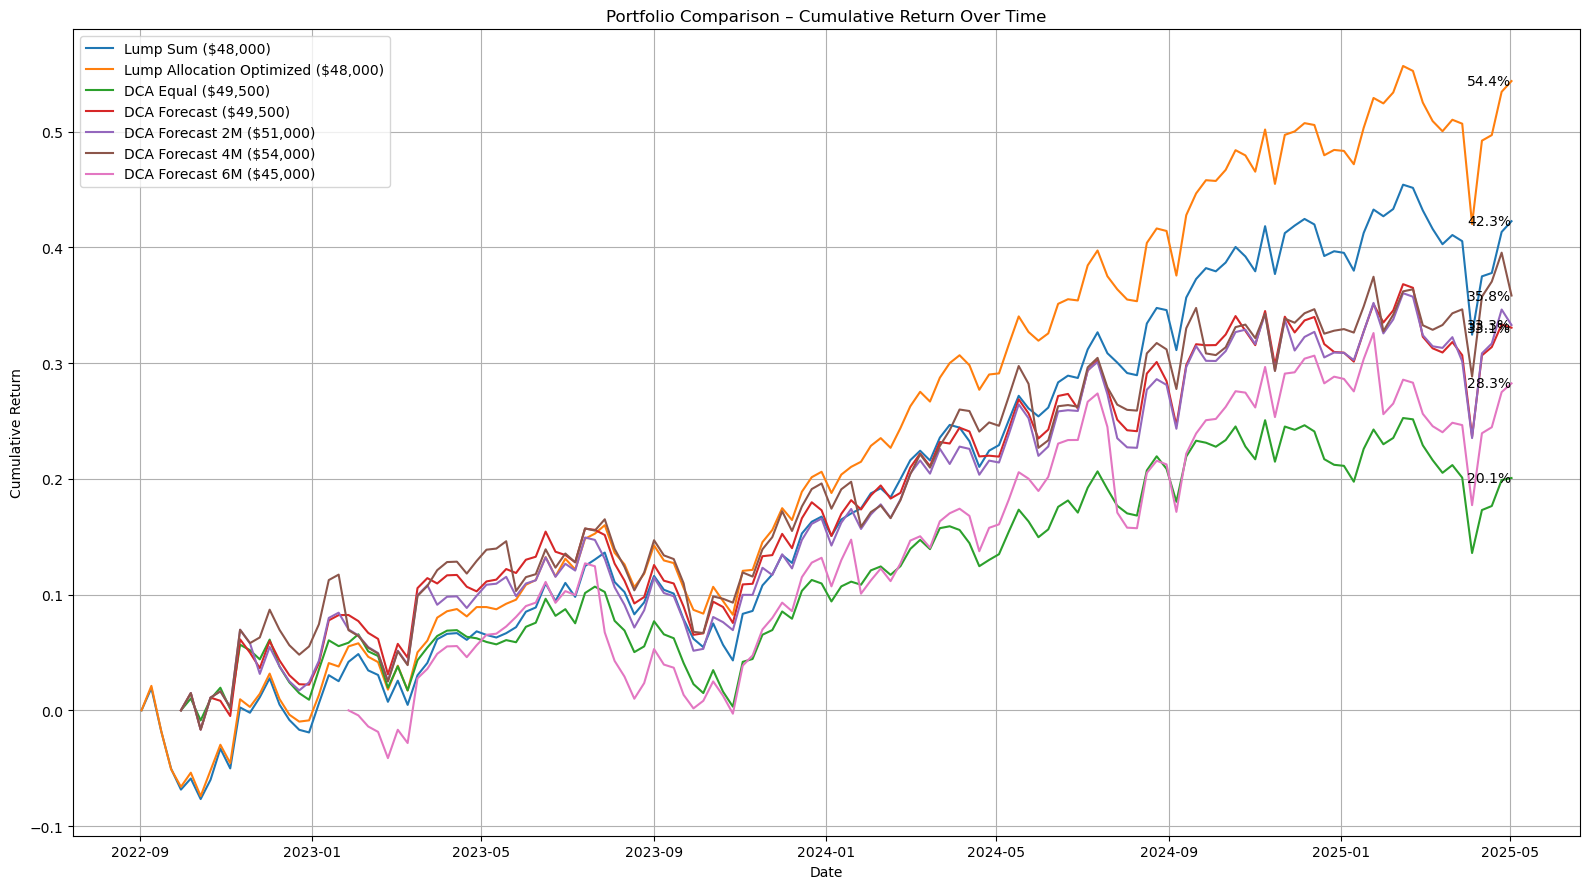

In [81]:
#7 Plotting Cumulative Retrun for every portfolio
# === 7.1 Portfolio name mapping with total invested label ===
portfolio_tables = {
    'Lump Sum': lump_sum_df,
    'Lump Allocation Optimized': lump_allocation_optimized,
    'DCA Equal': dca_equal_df,
    'DCA Forecast': dca_forecast_df,
    'DCA Forecast 2M': dca_forecast2months_df,
    'DCA Forecast 4M': dca_forecast4months_df,
    'DCA Forecast 6M': dca_forecast6months_df
}

# === 7.2 Plot cumulative returns with annotations ===
plt.figure(figsize=(16, 9))

for name, df in portfolio_tables.items():
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    total_invested = df['Total Invested'].iloc[-1]
    label = f"{name} (${total_invested:,.0f})"

    plt.plot(df.index, df['Cumulative Return'], label=label)

    # Annotate final return
    final_return = df['Cumulative Return'].iloc[-1]
    final_date = df.index[-1]
    plt.text(final_date, final_return, f"{final_return*100:.1f}%", 
             fontsize=10, va='center', ha='right')

plt.title('Portfolio Comparison – Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [159]:
import pandas as pd

# === 8.0 Define Current Holdings ===
current_holdings = {
    'SPY': 17,
    'QQQ': 16,
    'SCHD': 150,
    'TLTW': 120,
    'GLD': 0
}

# === 8.1 Latest Available Prices ===
latest_date = portfolio_df4.index[-1]
latest_prices = prices.loc[latest_date]

# === 8.2 Forecast for +4 weeks from latest_date ===
forecast_horizon = latest_date + pd.Timedelta(days=28)
latest_pred_returns = {}
for etf in etfs:
    forecast_df = forecast_dict[etf].set_index('ds')
    try:
        forecast_row = forecast_df.loc[forecast_df.index >= forecast_horizon].iloc[0]
        latest_pred_returns[etf] = forecast_row['yhat']
    except IndexError:
        latest_pred_returns[etf] = 0

# === 8.3 Forecast-Based Weights ===
positive_sum = sum(max(v, 0) for v in latest_pred_returns.values())
if positive_sum > 0:
    latest_weights = {etf: max(latest_pred_returns[etf], 0) / positive_sum for etf in etfs}
else:
    latest_weights = {etf: 1 / len(etfs) for etf in etfs}

# === 8.4 Investment Plan ===
investment_amount = 5000
allocation = {etf: investment_amount * latest_weights[etf] for etf in etfs}

# === Round shares to whole numbers ===
shares_to_buy_int = {etf: int(allocation[etf] // latest_prices[etf]) for etf in etfs}

# === Calculate actual money spent ===
actual_spent = {etf: shares_to_buy_int[etf] * latest_prices[etf] for etf in etfs}
total_spent = sum(actual_spent.values())
remaining_cash = investment_amount - total_spent

# === Update portfolio ===
previous_units = pd.Series(current_holdings)
new_units = pd.Series(shares_to_buy_int)
total_units_after = previous_units + new_units

# === Final portfolio values ===
latest_value_by_etf = total_units_after * latest_prices
total_value_after_buy = latest_value_by_etf.sum()
percent_holdings_final = (latest_value_by_etf / total_value_after_buy) * 100

# === Final Output Table ===
result_table = pd.DataFrame({
    'Investment Date': latest_date,
    'Money Invested ($)': pd.Series(actual_spent),
    '# of Shares Bought': new_units,
    'Total Shares': total_units_after,
    'Final Holdings (%)': percent_holdings_final
}).round(4)

# === Add Remaining Cash Row ===
cash_row = pd.DataFrame({
    'Investment Date': latest_date,
    'Money Invested ($)': remaining_cash,
    '# of Shares Bought': '',
    'Total Shares': '',
    'Final Holdings (%)': ''
}, index=['Remaining Cash'])

# === Combine and show final table ===
final_table = pd.concat([result_table, cash_row])
final_table


,Investment Date,Money Invested ($),# of Shares Bought,Total Shares,Final Holdings (%)
SPY,2025-05-02,554.320000,1,18,35.4215
QQQ,2025-05-02,951.060000,2,18,30.3867
SCHD,2025-05-02,983.820000,38,188,17.2792
TLTW,2025-05-02,997.080000,42,162,13.653
GLD,2025-05-02,918.180000,3,3,3.2596
Remaining Cash,2025-05-02,595.540035,,,
